# Chapter 8: 포아송 과정

- 이 장에서는 임의의 시간에 발생하는 이벤트를 나타내는 모델에 사용되는 포아송 과정에 대해 설명한다. 
- 포아송 과정의 한 예로, 축구에서 골을 넣는 것에 대해 모델을 만들 것이다. 
- 경기에서 득점한 것을 포아송 과정의 한 매개변수로 사용하고, 이후 득점을 예측하기 위해 사후분포를 사용할 것이다.
- 이 과정을 통해 월드컵 문제를 풀어보자.

## 8.1 월드컵 문제

- 2018년 월드컵에서 프랑스는 크로아티아에게 4:2 로 이겼다. 이 결과를 보면 다음과 같은 질문을 할 수 있다. 
    1. 프랑스가 크로아티아보다 나은 팀일 가능성은 어느 정도일까?
    2. 재경기를 한다면, 프랑스가 다시 이길 확률은 얼마일까?
- 이 질문에 대답을 하려면 몇 가지 모델링을 위한 전제를 해야 한다.
  - 첫째로, 어떤 팀이든 다른 팀과 경기를 할 때 있어서 경기당 몇 개의 골을 넣을 것인지에 대한 임의의 득점율이 있다. 여기서는 변수 lam 으로 나타내고, 글에서는 $\lambda$라고 표현한다.
  - 두번째로 공이 골에 들어갈 확률은 경기 90분 내내 동일하다고 가정한다. 즉 $ p = \frac{1}{\lambda} $ 이다. 
  - 세번째로 한 팀에서는 일 분 내에 2점을 내지 않는다고 가정한다. 
- 물론 이 가정은 실제의 문제와 다르지만, 단순화를 위한 효과적인 가정이다. 조지 박스는 이에 대해 모든 모델은 다 잘못되었지만, 일부는 유용하다고 평가했다.
- 이 경우 대충이나마 가정이 사실이라면, 경기에서 골이 들어갈 횟수는 포아송분포를 따른다고 볼 수 있으며 유용한 모델을 설계할 수 있다.

## 8.2 포아송 분포

- 한 경기에서 골의 수가 득점률 $\lambda$ 인 포아송분포를 따른다고 하면, k점을 얻을 확률은 모든 양수 k에 대해 다음과 같다.
- $$ p(k) = \frac{\lambda^{k} * e^{-\lambda * k}}{k!}$$
- scipy 에는 포아송분포를 다루는 객체, poisson 이 있다. 다음과 같이 $\lambda = 1.4$ 인 포아송분포를 만들어보자.
- poisson 함수는 포아송함수의 확률질량함수(Probability Mass Function; PMF)를 구한다.

In [1]:
from scipy.stats import poisson

lam = 1.4
dist = poisson(lam)
type(dist)

scipy.stats._distn_infrastructure.rv_discrete_frozen

아래 결과는 경기당 득점률이 1.4골인 경우에서, 한 경기에 4골을 넣을 확률을 구한다. 

결과는 약 4 %이다. 다음 함수를 사용해서 포아송분포를 나타내는 Pmf를 만들어보자. 

In [2]:
k = 4
dist.pmf(k)

0.039471954028253146

이 과정을 축약해서 함수로 만들어보자. 

make_poisson_pmf 는 득점율 lam과 값의 배열 qs를 사용해서 포아송 PMF를 만든다. 결괏값으로는 Pmf 객체를 반환한다.

하나의 예로, lam = 1.4 인 경우 0부터 9까지 득점 k에 대한 분포를 구해보자.

In [3]:
from empiricaldist import Pmf 

def make_poisson_pmf(lam: float, qs: list)->Pmf:
    """make_poisson_pmf 는 득점율 lam과 값의 배열 qs를 사용해서 포아송 PMF를 만든다. 결괏값으로는 Pmf 객체를 반환"""
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

0    0.246598
1    0.345237
2    0.241666
3    0.112777
4    0.039472
5    0.011052
6    0.002579
7    0.000516
8    0.000090
9    0.000014
dtype: float64


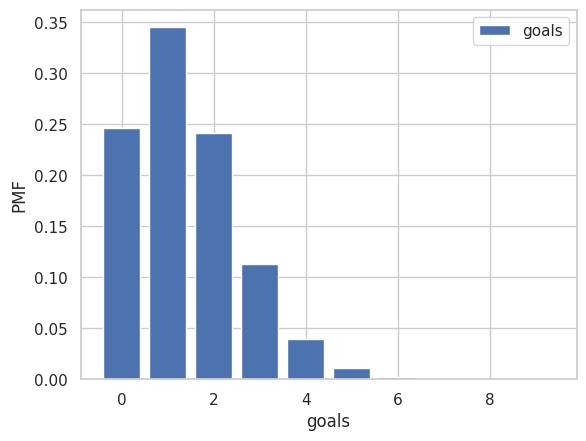

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pmf_goals = make_poisson_pmf(lam = 1.4, qs = np.arange(0, 10))
print(pmf_goals)
sns.set(style = 'whitegrid')
pmf_goals.bar(label = 'goals')
plt.xlabel('goals')
plt.ylabel('PMF')
plt.legend()
plt.show()

- 가장 가능성 높은 결과는 0,1,2 다. 더 큰 값도 가능하지만 가능성은 점점 낮아진다. 7 이상의 값은 무시해도 될 정도로 가능성이 낮다. 

- 이 분포를 보면 우리가 만약 득점율을 안다면 득점수도 예측할 수 있음을 알 수 있다. 

- 그럼 다시 돌아와서, 주어진 득점 수를 통해 득점률에 대해 무엇을 알 수 있을까? 

- 이 문제에 답하려면, lam의 가능한 값의 범위와 점수를 보기 전의 확률을 나타내는 사전분포에 대해 고려해 보아야 한다. 


## 8.3 감마분포

- 축구 경기를 본 적이 있다면, 득점율 lam에 대해서 어느 정도는 알고 있을 것이다. 많은 경기에서 양 팀의 득점 수는 작다. 

- 간혹 특이한 경우 한 팀이 5점 이상의 득점을 하기도 하지만, 10점을 넘어서는 경우는 거의 없다.

- 이전 월드컵의 데이터를 사용해서 각 팀이 평균 경기당 1.4점을 얻는다고 추정했다. 그러므로 lam의 평균을 1.4라고 설정한다. 

- 강한 팀이 약한 팀과 붙었을 경우 lam이 더 높을 것이라고 예측할 수 있다. 약한 팀이 강한 팀과 붙었을 경우, lam은 이보다 더 낮을 것이다. 
- 득점율을 모델링하기 위해서, 여기서는 감마분포를 사용했다. 이 분포를 선택한 이유는 다음과 같다. 
  1. 득점율은 연속형이고, 0 이상의 수이므로 감마분포가 이에 적합하다. 
  2. 감마분포는 평균값 alpha 만을 매개변수로 사용한다. 따라서 평균값만으로 우리가 원하는 감마분포를 만들기가 용이하다. 
  3. 차차 살펴보겠지만, 감마분포는 우리가 축구의 점수에 대해서 아는 것을 생각해 봤을 때 괜찮은 선택지다. 

- 한 가지 이유가 더 있지만, 이에 대해서는 18장에서 살펴보도록 하겠다. 
- scipy에는 감마분포를 나타내는 객체인 gamma가 있다. gamma 객체에는 감마분포의 확률밀도함수를 구하는 pdf()가 있다. 

In [5]:
from scipy.stats import gamma

alpha = 1.4 
qs = np.linspace(0,10,101) # qs = 가능한 값, 인덱스
ps = gamma(alpha).pdf(qs) # ps = 가능한 값의 확률, pdf(pmf), 확률밀도함수

- 매개변수 alpha 는 분포의 평균이다. qs는 0부터 10까지의 가능한 lam의 값이다. ps는 확률밀도로, 정규화되지 않은 확률로 볼 수 있다. 
- 이를 정규화하려면 이 값을 Pmf에 넣고 normalize()를 호출한다. 

In [6]:
from empiricaldist import Pmf

prior = Pmf(ps,qs)
prior.normalize()

9.889360237140306

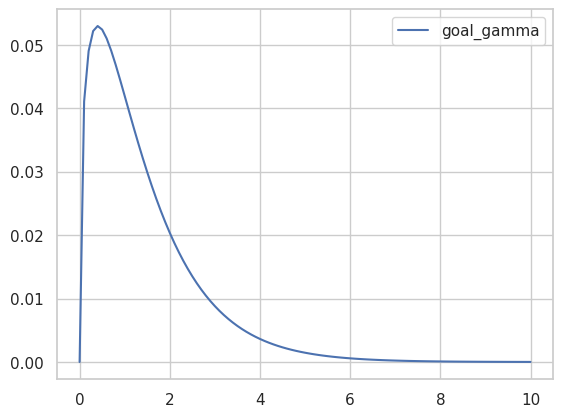

In [7]:
prior.plot(label = 'goal_gamma')
plt.legend()
plt.show()

- 이 분포는 우리가 득점에 대해 알고 있는 사전 지식을 나타낸다. 
- lam 은 보통 2보다 작고, 어쩌다 6점까지 갈 수 있지만 이보다 높은 경우는 거의 없다. 
- 일반적으로 대개의 사람들은 사전확률의 상세한 내용에 대해서 동의하지는 않지만, 추정을 위해 이 정도면 충분하다. 그럼 이제 갱신을 해보자.

## 8.4 갱신

- 득점률 $\lambda$가 주어졌을 때, $k$ 만큼 득점을 할 확률을 구해야 한다고 해보자. 
- 이는 명확하게 포아송분포를 통해 구할 수 있다. 예를 들어 람다가 1.4라면, 경기에서 4점을 낼 확률은 다음과 같다.

In [8]:
lam = 1.4
poisson(lam).pmf(4)

0.039471954028253146

이번에는 가능한 람다의 값에 대한 배열이 있다고 해보자. 이 경우 lam을 가정하는 각각의 값에 대한 데이터의 가능도를 다음과 같이 구할 수 있다. 

In [9]:
lams = prior.qs
k = 4
likelihood = poisson(lams).pmf(k)

갱신(bayesian update)에 필요한 것은 이것이 전부다. 사후확률분포를 얻으려면 사전확률에 여기서 구한 가능도를 곱한 후 정규화한다. 

다음 함수는 여기까지의 과정을 캡슐화한다. 

In [10]:
def update_poisson(pmf:Pmf, k:any)->None:
    lams = pmf.qs
    likelihood = poisson(lams).pmf(k)
    pmf *= likelihood # == pmf.ps * likelihood
    pmf.normalize()

첫번째 인자는 사전확률분포이고, 두번째 인자는 득점 수다. 

예를 들어 프랑스가 4점을 냈다면, 아래와 같이 업데이트한다.

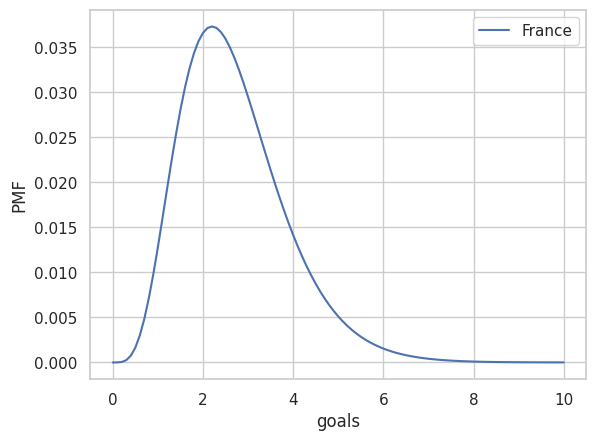

In [11]:
france = prior.copy()
update_poisson(france, 4)
france.plot(label = 'France')
plt.xlabel("goals")
plt.ylabel('PMF')
plt.legend()
plt.show()

In [12]:
def plt_default(x_label:str)->None:
    plt.xlabel(x_label)
    plt.ylabel("PMF")
    plt.legend()
    plt.show()

In [13]:
croatia = prior.copy()
update_poisson(croatia, 2)

- 프랑스는 4점을 낸 후, 사후분포의 평균이 2.7이 되었다. 이 결과는 전형적인 베이지안 갱신이다.

- 이처럼 사후평균은 사전평균과 데이터 간의 절충안 어딘가 사이에 위치한다. 

## 8.5 우세할 확률

- 지금까지 각 팀의 사후확률분포를 살펴봤으니, 처음의 질문에 대답할 수 있다. 프랑스가 더 나은 팀일 가능성은 어느 정도일까?

- 모델에서 '더 나은 팀'이라는 뜻은 상대팀보다 득점률이 더 높다는 뜻이다. 

- 사후분포를 사용해서 프랑스의 분포에서 임의의 값을 선택했을 때, 이 값이 크로아티아의 분포에서 선택한 임의의 값보다 더 클 확률을 구할 수 있다.

- 한 가지 방법은 두 분포의 모든 값의 쌍을 나열한 후, 한 값이 다른 값보다 클 확률을 모두 더한다.

In [14]:
def prob_gt(pmf1:Pmf, pmf2:Pmf):
    """우세할 확률을 구함"""
    total = 0
    for q1,p1 in pmf1.items():
        for q2,p2 in pmf2.items():
            if q1 > q2:
                total += p1 * p2
    return total

- 이는 6.4절의 'addends' 에서 합의 분포를 구한 것과 같은 메서드를 사용한다. 사용한 방법은 다음과 같다. 

In [15]:
prob_gt(france, croatia)

0.7499366290930155

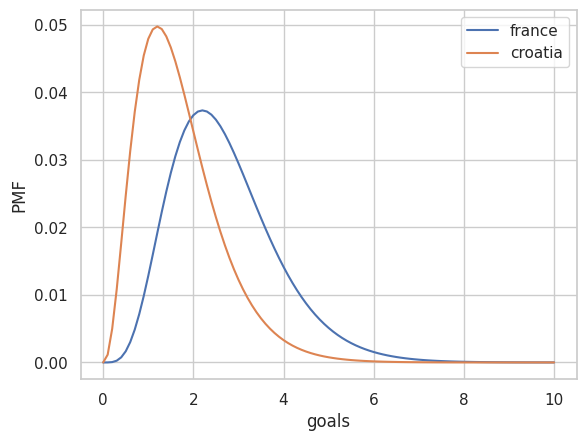

In [16]:
france.plot(label = 'france')
croatia.plot(label = 'croatia')
plt_default("goals")

## 8.6 다음 경기 예측

- 그럼 이제 두번째 질문을 살펴보자. 만약 같은 팀이 다시 경기를 한다면, 크로아티아가 다시 이길 확률은 얼마일까? 
- 이 질문에 대답하려면, 한 팀이 얻을 점수에 대한 사후예측분포를 만들어야 한다.
- 만약 득점률 lam을 안다면, 점수 분포는 lam을 인수로 갖는 포아송분포가 된다. 
- lam을 모르는 상태라면 득점 분포는 lam의 여러 값에 대한 포아송분포 혼합이 된다. 
- 우선 각 lam의 값에 대한 Pmf 객체의 sequence data를 만들 것이다. 

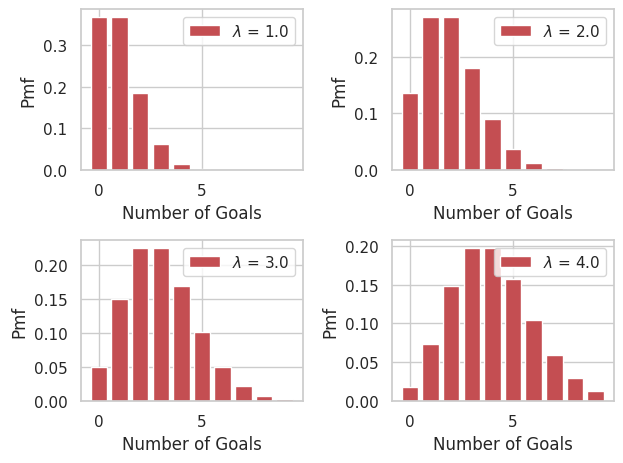

In [17]:
goals = np.arange(0,10)
pmf_seq = [make_poisson_pmf(lam, goals) for lam in prior.qs] # prior.qs = np.linspace(0,10,101)

for i, index in enumerate([10,20,30,40]):
    plt.subplot(2,2,i+1)
    lam = prior.qs[index]
    pmf = pmf_seq[index]
    pmf.bar(label = f'$\lambda$ = {lam}', color ='C3')
    plt.xlabel('Number of Goals')
    plt.ylabel('Pmf')
    plt.legend()
    plt.tight_layout()

plt.show()


- 위의 분포는 lam의 몇 개의 값에 대한 분포가 어떤 모양인지를 알려준다. 

- 예측분포는 이 Pmf 객체에 사후확률이 가중치로 부여된 혼합 형태다. 이런 혼합 형태를 구하는 경우 7.6 절의 '일반적인 혼합' 에서 사용한 make_mixture()를 사용할 수 있다. 

```python
def make_mixture(pmf:Pmf, pmf_seq:list or tuple)->Pmf:
    """
    make mixture distribution
    각 주사위가 선택될 사후확률 pmf_dice
    각 주사위가 가능한 확률을 나타내는 Pmf 객체들의 sequence 데이터
    """
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis = 1)
    return Pmf(total)

```

이하는 재경기를 하는 경우의 프랑스의 예측분포이다. 

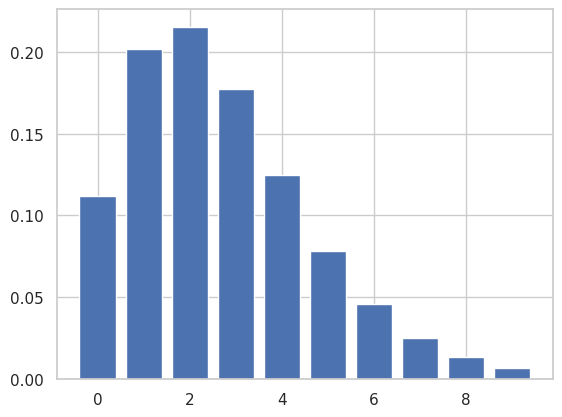

In [18]:
from utils import make_mixture

pred_france = make_mixture(france, pmf_seq)
pred_france.bar()

- 이 분포에는 불확실한 부분이 두 가지가 있다.
    1. lam의 실제 분포를 모른다.
    2. 다음 경기에서의 득점 수를 모른다. 

다음은 크로아티아의 예측분포이다. 

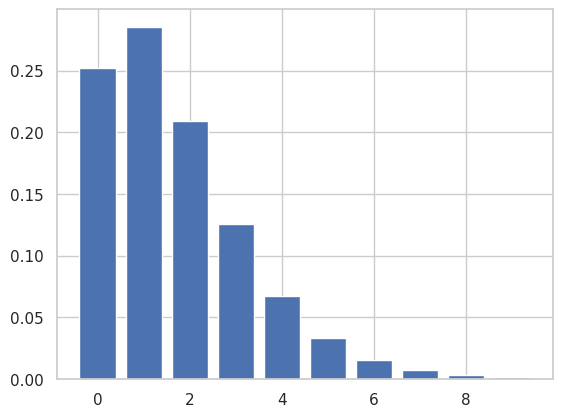

In [19]:
pred_croatia = make_mixture(croatia, pmf_seq)
pred_croatia.bar()

이 분포를 사용해서 재경기에서 프랑스가 이기거나 비기거나 질 확률을 구할 수 있다. 

In [20]:
win = Pmf.prob_gt(pred_france, pred_croatia)
win

0.5703522415934519

In [21]:
lose = Pmf.prob_le(pred_france, pred_croatia)
lose

0.42964775840654823

In [22]:
tie = Pmf.prob_eq(pred_france, pred_croatia)
tie

0.16521399583418947

비기는 경우의 반은 프랑스가 이긴다고 가정하면(비겨서 승부차기를 했을 때 승률이 50%), 프랑스가 재경기에서 이길 확률은 (win + tie/2), 약 65%다. 

In [23]:
(win + tie/2)

0.6529592395105466

이는 프랑스가 더 나은 팀일 가능성이었던 75%보다는 다소 낮다. 

득점율을 구하는 것보다 단일 경기의 결과는 덜 확실하기 때문에, 충분히 그럴 수 있다.

프랑스가 더 나은 팀이라 할지라도 경기에서는 질 수 있다. 

## 8.7 지수분포

- 이 장의 끝의 실습으로, 월드컵 문제를 다음과 같이 변형한 내용을 살펴보자. 
  - 2014년 월드컵에서 독일은 브라질과 준결승 경기를 가졌다. 독일은 11분 후와 23분 후에 한번씩 득점을 했다. 
  - 이 경기에서 90분 후 독일은 몇 점을 냈을까? 5개의 골을 더 넣었을 확률은 얼마일까?
- 여기에서 데이터는 정해진 시간에서의 득점 수가 아니라 골을 넣었을 때 사이의 시간임을 기억하자. 
- 이런 데이터의 가능도를 계산하려면 포아송 프로세스를 다시 사용하는 것이 좋다. 
- 각 팀이 상수의 득점율을 가지고 있다면, 득점간 시간은 지수분포를 따르게 된다. 
- 득점율이 $\lambda$라면 득점간 시간 t는 지수분포의 PDF에 비례한다. 
- $$ \lambda * exp(-\lambda t) $$
- t 는 연속적인 값이므로 이 식의 값은 확률이 아니라 확률밀도다. 
- 하지만 이 값은 데이터의 확률에 비례하므로 이를 베이지안 갱신의 가능도처럼 활용할 수 있다. 
- 지수분포의 PDF는 구하기 쉬우므로 직접 함수를 만들어 사용하자. 

In [24]:
def expo_pdf(t, lam):
    """지수분포의 pdf"""
    pdf = lam * np.exp(-lam * t)
    return pdf

지수분포가 어떻게 생겼는지 확인해보기 위해, 일단 lam이 1.4라고 가정하고 t의 분포를 구해보자. 

In [25]:
lam = 1.4
qs = np.linspace(0,4, 101)
ps = expo_pdf(qs, lam)
pmf_time = Pmf(ps, qs)
pmf_time.normalize()

25.616650745459093

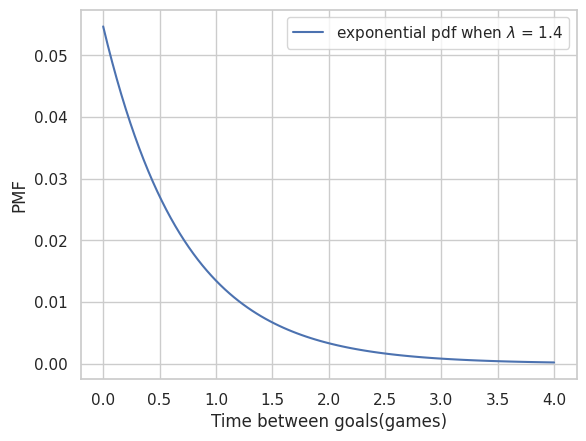

In [26]:
pmf_time.plot(label = f'exponential pdf when $\lambda$ = 1.4')
plt_default('Time between goals(games)')

- 직관과는 거리가 있지만, 사실은 득점을 하고 나서 득점할 가능성이 가장 높은 시간은 연달아 골을 넣는 것이다. 
- 시간이 지날수록, 시간 간격별 성공확률은 점점 더 떨어진다. 
- 1.4의 득점율을 가진 팀이 득점을 하는데 한 경기 이상이 걸릴 수는 있지만, 두 경기를 넘길 가능성은 거의 없다. 

## 8.8 요약

- 이 장에서는 세 가지의 새로운 분포를 소개했기 때문에 한번에 바로 이해하기 어려울 수 있다. 
- 일단 한번 복습해보자.

    1. 시스템이 포아송 모델을 만족한다면, 특정 기간 동안 일어나는 사건의 수는 이산확률분포인 포아송분포($0~\infty$)를 따른다. 실제로 우리는 보통 특정 수 이상의 값은 낮은 확률을 가지므로 무시한다.

    2. 또한 포아송모델 하에서는 사건 간 간격은 연속확률분포인 지수분포($0~\infty$)를 따른다. 이 분포는 연속적이므로 확률질량함수 대신 확률밀도함수로 나타낸다. 하지만 우리가 데이터의 가능도를 구하기 위해 지수분포를 사용할 때는 밀도를 표준화되지 않은 확률로 사용한다. (= 똑같이 사용한다는 뜻)

    3. 포아송분포와 지수분포는 람다나 lam로 표기되는 사건의 비율을 매개변수로 사용해서 표기한다.

    4. $\lambda$의 사후분포로는 0부터 무한까지의 값에 대한 연속분포인 감마분포를 사용했다. 하지만 이 분포를 구간을 나눈 PMF처럼 사용한다. 감마분포는 평균값인 $\alpha$라고 쓰이는 매개변수를 사용한다.

- 감마분포를 선택한 이유는 득점율에 대한 배경 지식과 모양이 일치하기 때문이다. 다른 분포를 사용할 수도 있지만, 18장을 보면 감마분포가 꽤 좋은 선택임을 알 수 있다.

## 8.9 연습문제

### 문제 8.1

앞에서 시작했던 문제를 마무리해보자.

  - 2014년 월드컵에서 독일은 브라질과 준결승 경기를 가졌다. 독일은 11분 후와 23분 후에 한번씩 득점을 했다. 
  - 이 경기에서 90분 후 독일은 몇 점을 냈을까? 5개의 골을 더 넣었을 확률은 얼마일까?

이 문제를 풀 때 내가 제안하는 방식은 다음과 같다.

1. 앞서 사용한 것과 같이 동일한 감마 사전분포를 사용해서, 각 가능한 lam에 대해 11분 후의 득점 수의 가능도를 구한다. 이 때 분을 경기 수로 변환하는 것을 잊지 말자.
2. 독일의 첫 득점 후의 lam의 사후분포를 구한다.
3. 12분이 더 지난 후에 한 점을 더 얻은 후 점수의 가능도를 구한 후 새로 갱신한다. 사전확률, 1점 득점 후의 사후확률, 2점 득점 후의 사후확률을 그려본다.
4. 독일이 남은 경기 시간인 (90-23) 분 동안 얻을 점수의 사후예측분포를 구한다.
   1. 주의: 경기시간의 비율에 대해 예측 득점 수를 어떻게 만들지 고민해야 한다.
5. 남은 시간 동안 5점 이상의 점수를 얻을 확률을 구해보자. 

In [27]:
# 1 

alpha = 1.4 
qs = np.linspace(0,10,101) # qs = lam 이 취할 수 있는 가능한 값, 인덱스
ps = gamma(alpha).pdf(qs) # ps = 가능한 값의 확률, pdf(pmf), 확률밀도함수

prior = Pmf(ps,qs) # lam_pmf
prior.normalize()

9.889360237140306

In [28]:
#2 minute을 경기수로 변환 = 지수분포

def update_expo(pmf, data):
    """ Update based on an observed interval 
    pmf : prior Pmf
    data: time between goals in minute
    """
    t = data/90 
    lams = pmf.qs
    likelihood = expo_pdf(t, lams) # expo_pdf = lam * np.exp(-lam * t)
    pmf *= likelihood
    pmf.normalize()

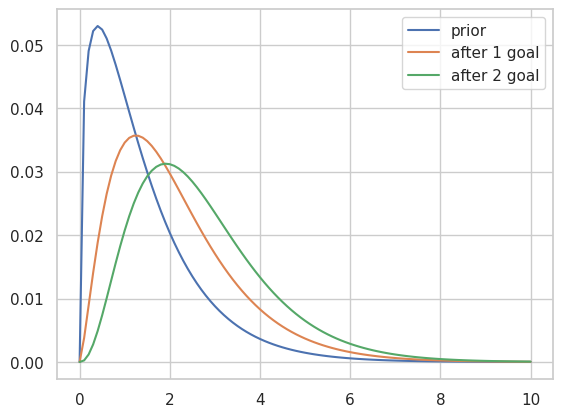

In [29]:
germany = prior.copy() # = 독일이 경기당 넣을 득점은 평균이 alpha = 1.4 인 감마 사전확률분포를 따른다고 가정

# 각 가능한 lam에 대해 11분 후, 23분 후의 득점 수의 가능도
prior.plot(label = 'prior')
update_expo(germany, 11)
germany.plot(label = 'after 1 goal')
update_expo(germany, 12)
germany.plot(label = 'after 2 goal')

plt.legend()
plt.show()

In [31]:
# the mean values of `lam` after each update
print(f'germany point probability: {germany.mean()}')

germany point probability: 2.703059034926364


In [45]:
germany.qs

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

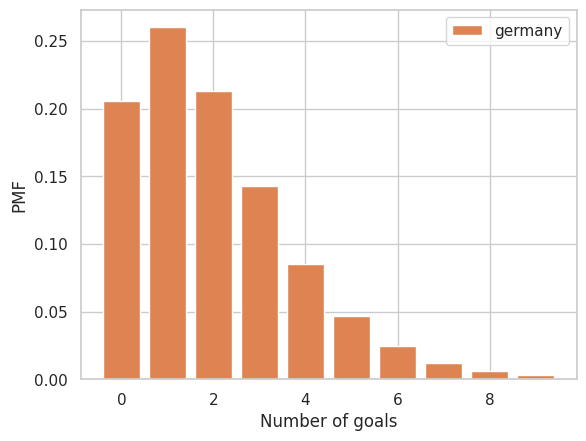

In [43]:
# t = (90 - 23)/90 이 되었으므로, 포아송분포를 이에 맞게 수정해주자. 
# sector 8.6의 다음 경기 예측 활용과 똑같음

t = (90-23) / 90 
pmf_seq = [make_poisson_pmf(lam * t, goals) for lam in germany.qs] # goals = np.arange(0,10)
pred_germany = make_mixture(germany, pmf_seq) # 23분동안의 골이 반영된 분포 + 기존 예측분포
pred_germany.bar(color = 'C1', label = 'germany')
plt_default('Number of goals')

In [44]:
print(f'이만큼 점수를 내리라 예측합니다. : {pred_germany.mean()}')
print(f'5점 이상의 점수를 낼 확률: {pred_germany.prob_gt(5)}')

이만큼 점수를 내리라 예측합니다. : 1.9994371012513807
5점 이상의 점수를 낼 확률: 0.045752342522231974


### 문제 8.2 

월드컵 문제의 첫번째 버전으로 돌아가서 프랑스와 크로아티아가 경기를 한다고 가정하자. 이 때 프랑스가 먼저 득점할 확률은 얼마인가?

1. 서로 0:0 인 상황
2. lambda = 1.4
3. t = 90
4. 누가 '먼저' 넣냐니까, t에 관한 수식일 것이다. 이는 지수분포를 사용해 문제를 해결한다. 

In [ ]:
def make_expo_pmf(lam, high):
    """Make a PMF of an exponential distribution.
    
    lam: event rate
    high: upper bound on the interval `t`
    
    returns: Pmf of the interval between events
    """
    qs = np.linspace(0, high, 101)
    ps = expo_pdf(qs, lam)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [ ]:
# Solution

# Here are the predictive distributions for the 
# time until the first goal

pmf_seq = [make_expo_pmf(lam, high=4) for lam in prior.qs]

In [ ]:
# Solution

# And here are the mixtures based on the two posterior distributions

pred_france = make_mixture(france, pmf_seq)
pred_croatia = make_mixture(croatia, pmf_seq)

In [ ]:
# Solution

# Here's what the posterior predictive distributions look like

pred_france.plot(label='France', color='C3')
pred_croatia.plot(label='Croatia', color='C0')
plt_default('Time between goals')

### 문제 8.3

- 하키리그 결승전에서,A팀이 B팀을 상대로 7판 4선승제를 했다. A팀은 처음 두 경기를 0:1, 2:3 으로 졌지만 다음 두 경기를 8:1, 4:0으로 이겼다.
- 이 시점에서 A가 다음 경기를 이길 확률은 얼마일까? 그리고 이 팀이 우승할 확률은 얼마일까?(=2승을 먼저 더 할 확률)
- 이 때 분포는 평균 2.8의 감마분포를 따른다. 
- 이 경기의 결과는 어떤 면에서 포아송 모델의 가정과 어긋날까? 이런 충돌이 예측 결과에 어떤 영향을 미칠까?